In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def add_basic_stats(row, moves, pref=""):

    row[pref + 'winrate_mean'] = np.mean(moves.winrate_delta)
    row[pref + 'score_mean'] = np.mean(moves.score_delta)
    row[pref + 'score_var'] = np.var(moves.score_delta)
    row[pref + 'selfplay_mean'] = np.mean(moves.selfplay_delta)
    row[pref + 'utility_mean'] = np.mean(moves.utility_delta)
    row[pref + 'winrate_beauty_percent'] = np.mean([x > 0 for x in moves.winrate_delta])
    row[pref + 'score_beauty_percent'] = np.mean([x > 0 for x in moves.score_delta])


def add_advanced_stats(row, moves, pref=""):
    moves.score_delta.sort()
    moves.winrate_delta.sort()

    row[pref + 'score25p'] = moves.score_delta[int(moves.cnt_moves * 0.25)]
    row[pref + 'score75p'] = moves.score_delta[int(moves.cnt_moves * 0.75)]
    row[pref + 'score_max'] = np.max(moves.score_delta)
    row[pref + 'score_min'] = np.min(moves.score_delta)
    row[pref + 'winrate25p'] = moves.winrate_delta[int(moves.cnt_moves * 0.25)]
    row[pref + 'winrate75p'] = moves.winrate_delta[int(moves.cnt_moves * 0.75)]

    row[pref + 'score_five_best_mean'] = np.mean(moves.score_delta[-5:])
    row[pref + 'score_five_worst_mean'] = np.mean(moves.score_delta[:5])

    row[pref + 'stddev_last'] = moves.stddev_delta[-1]
    moves.stddev_delta.sort()
    row[pref + 'stddev_mean'] = np.mean(moves.stddev_delta)
    row[pref + 'stddev50p'] = moves.stddev_delta[int(moves.cnt_moves * 0.5)]

    row[pref + 'score50p'] = moves.score_delta[int(moves.cnt_moves * 0.5)]

    row[pref + 'winrate_midmean'] = np.mean(
        moves.winrate_delta[int(moves.cnt_moves * 0.25):int(moves.cnt_moves * 0.75)])
    row[pref + 'score_midmean'] = np.mean(moves.score_delta[int(moves.cnt_moves * 0.25):int(moves.cnt_moves * 0.75)])


def get_index_dan(rank):
  for i in range(len(rank)):
    if rank[i] in ['k', 'd']:
      return i
  return -1


def get_int_from_rank(rank):
    ind = get_index_dan(rank)
    if ind < 0 or rank[0] == 'P' or not rank[:ind].isdigit():
        return None
    if rank[ind] == 'k':
        return -int(rank[:ind]) + 1
    else:
        return int(rank[:ind])


def get_rank_from_int(x):
    if x > 0:
        return str(x) + "d"
    else:
        return str(-x + 1) + "k"


def int_from_player(player):
    return int(player == 'W')


def player_from_int(x):
    return 'W' if x == 1 else 'B'


def add_meta(row, player='W'):
    if row['Result'] == '?':
        row['game_result'] = 0
    else:
        row['game_result'] = int(row['Result'])
        if player == 'B':
            row['game_result'] = -row['game_result']
    row['color'] = int_from_player(player)
    row['rank'] = get_int_from_rank(row[player + '_rating'])
    row['game_length'] = len(row['W_move'].split()) + len(row['B_move'].split())


def convert_to_lists(df):
    for i, row in tqdm(df.iterrows()):
        try:
            row['W_scoreLead'] = [float(x) for x in row['W_scoreLead'].split()]
            row['B_scoreLead'] = [float(x) for x in row['B_scoreLead'].split()]
            row['W_scoreSelfplay'] = [float(x) for x in row['W_scoreSelfplay'].split()]
            row['B_scoreSelfplay'] = [float(x) for x in row['B_scoreSelfplay'].split()]
            row['W_scoreStdev'] = [float(x) for x in row['W_scoreStdev'].split()]
            row['B_scoreStdev'] = [float(x) for x in row['B_scoreStdev'].split()]
            row['W_utility'] = [float(x) for x in row['W_utility'].split()]
            row['B_utility'] = [float(x) for x in row['B_utility'].split()]
            row['W_winrate'] = [float(x) for x in row['W_winrate'].split()]
            row['B_winrate'] = [float(x) for x in row['B_winrate'].split()]
            df.loc[i] = row
        except Exception as e:
            print(e)
            df = df.drop(index=[i])          
    return df
    

class MovesInfo:
    def __init__(self, row, n_moves=None, player='W'):
        enemy = 'B' if player == 'W' else 'W'
        if player == 'B':
            moves_len = min(len(row['B_winrate']), len(row['W_winrate']) + 1)
        else:
            moves_len = min(len(row['W_winrate']), len(row['B_winrate']))

        if n_moves is None:
            start_ind = 0
        else:
            start_ind = max(moves_len - n_moves - 1, 0)

        end_ind = moves_len
        w_0 = []
        sc_0 = []
        ut_0 = []
        std_0 = []
        sf_0 = []
        if player == 'B':
            if start_ind == 0:
                w_0 = [0.475]
                sc_0 = [0.]
                ut_0 = [0.]
                std_0 = [19. - 0.07666535852999867 * 2]
                sf_0 = [0.]
            else:
                w_0 = [row[enemy + '_winrate'][start_ind - 1]]

                sc_0 = [row[enemy + '_scoreLead'][start_ind - 1]]
                ut_0 = [row[enemy + '_utility'][start_ind - 1]]
                std_0 = [row[enemy + '_scoreStdev'][start_ind - 1]]
                sf_0 = [row[enemy + '_scoreSelfplay'][start_ind - 1]]
        self.winrate_delta = np.array(row[player + '_winrate'][start_ind:end_ind]) - np.array(
            (w_0 + row[enemy + '_winrate'])[start_ind:end_ind])
        self.score_delta = np.array(row[player + '_scoreLead'][start_ind:end_ind]) - np.array(
            (sc_0 + row[enemy + '_scoreLead'])[start_ind:end_ind])
        self.utility_delta = np.array(row[player + '_utility'][start_ind:end_ind]) - np.array(
            (ut_0 + row[enemy + '_utility'])[start_ind:end_ind])
        self.selfplay_delta = np.array(row[player + '_scoreSelfplay'][start_ind:end_ind]) - np.array(
            (sf_0 + row[enemy + '_scoreSelfplay'])[start_ind:end_ind])
        self.stddev_delta = np.array(row[player + '_scoreStdev'][start_ind:end_ind]) - np.array(
            (std_0 + row[enemy + '_scoreStdev'])[start_ind:end_ind])

        if player == 'B':
            self.winrate_delta = -self.winrate_delta
            self.score_delta = -self.score_delta
            self.utility_delta = -self.utility_delta
            self.selfplay_delta = -self.selfplay_delta

        self.move = row[player + '_move'].split()
        self.cnt_moves = end_ind - start_ind


def add_all_game_stats(df, player = 'W'):
    df['winrate_mean'] = None
    df['score_midmean'] = None
    df['score_mean'] = None
    df['score_var'] = None
    df['winrate_beauty_percent'] = None
    df['score_beauty_percent'] = None
    df['utility_mean'] = None
    df['score25p'] = None
    df['score75p'] = None
    df['winrate25p'] = None
    df['winrate75p'] = None
    df['winrate_midmean'] = None
    df['score50p'] = None
    df['selfplay_mean'] = None
    df['stddev_mean'] = None
    df['stddev50p'] = None
    df['stddev_last'] = None
    df['score_max'] = None
    df['score_min'] = None
    df['score_five_best_mean'] = None
    df['score_five_worst_mean'] = None
    for i, row in tqdm(df.iterrows()):
        add_basic_stats(row, MovesInfo(row, player=player))
        add_advanced_stats(row, MovesInfo(row, player=player))
        df.loc[i] = row
    return df            


def get_start_of_yose(margin_moves, no_change_count=5):
    '''
    Находим сколько последних ходов мы будем считать что это йосе

    Будем идти с конца по массиву количества ходов на краю, если в массиве no_change_count одинаковых чисел,
    то мы останавливаемся и говорим, что тут началось йосе
    '''
    no_change = 1
    ans = len(margin_moves)
    for i in range(len(margin_moves) - 2, -1, -1):
        if margin_moves[i] == margin_moves[i + 1]:
            no_change += 1
        else:
            no_change = 1
        if no_change >= no_change_count:
            ans = len(margin_moves) - i - 1
            break
    return ans


def reset_basic_stats(df, pref):
    df[pref + 'winrate_mean'] = None
    df[pref + 'winrate_beauty_percent'] = None
    df[pref + 'score_beauty_percent'] = None
    df[pref + 'score_mean'] = None
    df[pref + 'selfplay_mean'] = None
    df[pref + 'score_var'] = None
    df[pref + 'utility_mean'] = None


def is_marginal_move(move):
    return (move[0] == 'a' or move[0] == 'b') or (move[0] == 'r' or move[0] == 's') or \
           (move[1] == 'a' or move[1] == 'b') or (move[1] == 'r' or move[1] == 's')


def count_of_marginal_moves(moves):
    ans = np.zeros(len(moves))
    for i in range(len(moves)):
        ans[i] = is_marginal_move(moves[i])
    ans = np.cumsum(ans)
    return ans


def add_yose_stats(df, player = 'W'):
    pref = 'yose_'
    reset_basic_stats(df, pref)
    df['yose_length'] = None
    df['yose_start'] = None
    df['yose_has'] = None
    for i, row in tqdm(df.iterrows()):
        marginal_moves = count_of_marginal_moves(row['W_move'].split())
        n_moves = get_start_of_yose(marginal_moves, 10)
        add_basic_stats(row, MovesInfo(row, n_moves, player=player), pref)
        row['yose_length'] = n_moves
        row['yose_start'] = len(row['W_move'].split()) - n_moves
        row['yose_has'] = row['yose_start'] != 0
        df.loc[i] = row
    return df    


def delta_moves(a, b):
    return abs(ord(a[0]) - ord(b[0])) + abs(ord(a[1]) - ord(b[1]))


def get_distance_of_moves(moves):
    ans = np.zeros(len(moves) - 1)
    for i in range(1, len(moves)):
        ans[i - 1] = delta_moves(moves[i], moves[i - 1])
    return ans


def get_distance_from_enemy(my_moves, enemy_moves):
    ans = np.zeros(min(len(my_moves), len(enemy_moves)))
    for i in range(min(len(my_moves), len(enemy_moves))):
        ans[i] = delta_moves(my_moves[i], enemy_moves[i])
    return ans


def add_last_moves_stats(df, n_moves, pref=None, player='W'):
    if pref is None:
        pref = str(n_moves) + "_"
    reset_basic_stats(df, pref)
    for i, row in tqdm(df.iterrows()):
        add_basic_stats(row, MovesInfo(row, n_moves, player=player), pref)
        df.loc[i] = row
        
    return df    


def add_dist_stats_to_row(row, player='W'):
    dist = get_distance_of_moves(row[player+'_move'].split())
    dist_enemy = get_distance_from_enemy(row['W_move'].split(), row['B_move'].split())
    dist.sort()

    row['dist_mean'] = np.mean(dist)
    row['dist_var'] = np.var(dist)
    row['dist_median'] = dist[len(dist) // 2]
    row['dist_percent_more_than_10'] = np.mean([x > 10 for x in dist])
    row['dist_percent_more_than_5'] = np.mean([x > 5 for x in dist])
    row['dist_percent_more_than_20'] = np.mean([x > 20 for x in dist])

    row['dist_from_enemy_mean'] = np.mean(dist_enemy)
    row['dist_from_enemy_var'] = np.var(dist_enemy)


def add_dist_stats(df, player='W'):
    df['dist_mean'] = None
    df['dist_var'] = None
    df['dist_median'] = None
    df['dist_percent_more_than_5'] = None
    df['dist_percent_more_than_10'] = None
    df['dist_percent_more_than_20'] = None

    df['dist_from_enemy_mean'] = None
    df['dist_from_enemy_var'] = None

    for i, row in tqdm(df.iterrows()):
       if len(row['W_move']) > 20:
        add_dist_stats_to_row(row, player=player)
        df.loc[i] = row
    return df    


def delete_non_scalar_parameters(df):
    df.drop(['W_rating', 'B_rating', 'W_move', 'B_move', 'W_scoreLead', 'B_scoreLead', 'W_scoreSelfplay',
             'B_scoreSelfplay', 'W_scoreStdev', 'B_scoreStdev', 'W_utility', 'B_utility',
             'W_winrate', 'B_winrate', 'Result'], axis=1, inplace=True)
    return df         


def add_delta_lists_to_row(row, moves, player='W'):
    row['winrate'] = moves.winrate_delta
    row['score'] = moves.score_delta


def kWorst(moves, cnt=5):
    moves.sort()
    return moves[:cnt][-1]  


def addWorstMoves(df, player='W'):
  for cnt in [5, 10]:
    for type_cls in ['score', 'winrate']:
      df['Worst_' + type_cls + str(cnt)] = np.array(df.apply(lambda row: kWorst(row[type_cls], cnt), axis = 1))
  return df    


def add_lists_to_df(df, player='W'):
    df['winrate'] = None
    df['score'] = None
    for i, row in tqdm(df.iterrows()):
        add_delta_lists_to_row(row, MovesInfo(row, player=player), player)
        df.loc[i] = row
    return df    


def add_meta_to_df(df, player='W'):
    df['game_length'] = None
    df['rank'] = None
    df['color'] = None
    df['game_result'] = None
    for i, row in tqdm(df.iterrows()):
        try:
            add_meta(row, player)
            df.loc[i] = row
        except Exception as e:
            print(e)
            df = df.drop(index=[i])
    return df        


def get_feature_df(df, player='W'):
    df = add_meta_to_df(df, player)
    df = convert_to_lists(df)
    df = add_all_game_stats(df, player)
    df = add_yose_stats(df, player)
    df = add_last_moves_stats(df, 10, player)
    df = add_last_moves_stats(df, 20, player)
    df = add_dist_stats(df, player)
    df = delete_non_scalar_parameters(df)
    return df


def get_df_with_lists(df, player='W'):
    df = add_meta_to_df(df, player)
    df = convert_to_lists(df)
    df = add_lists_to_df(df, player)
    df = addWorstMoves(df, player)
    df = delete_non_scalar_parameters(df)
    return df


In [2]:
from google.colab import drive
drive.mount('/content/drive')
katago = pd.read_csv('/content/drive/MyDrive/data_big.csv')[:150000]
katago.dropna(how = 'any', inplace= True)

Mounted at /content/drive


In [3]:
katago_white = get_df_with_lists(katago.copy(), player = 'W')

149313it [00:36, 4117.95it/s]
149313it [01:47, 1392.96it/s]
149313it [01:04, 2304.28it/s]


In [4]:
katago_white.groupby(
    ['rank']
).agg(
    {
        'Worst_score5': "median",
        'Worst_winrate5': "median",
        'Worst_score10': "median",
        'Worst_winrate10': "median",
    }
)

,Worst_score5,Worst_winrate5,Worst_score10,Worst_winrate10
rank,,,,
-14,-11.487627,-0.171440,-8.557395,-0.082573
-13,-10.701126,-0.155440,-7.843309,-0.076933
-12,-10.516502,-0.172476,-7.778724,-0.090166
-11,-10.178993,-0.159802,-7.458590,-0.084347
-10,-10.422403,-0.182492,-7.605252,-0.099269
-9,-9.208376,-0.146698,-6.561829,-0.075471
-8,-9.077448,-0.168114,-6.516157,-0.090279
-7,-9.057362,-0.169221,-6.412837,-0.094230
-6,-8.974980,-0.175212,-6.365786,-0.100089


In [5]:
katago_black = get_df_with_lists(katago.copy(), player = 'B')

149313it [00:38, 3913.57it/s]
149313it [01:43, 1442.72it/s]
149313it [01:06, 2262.11it/s]


In [6]:
katago_black.groupby(
    ['rank']
).agg(
    {
        'Worst_score5': "median",
        'Worst_winrate5': "median",
        'Worst_score10': "median",
        'Worst_winrate10': "median",
    }
)

,Worst_score5,Worst_winrate5,Worst_score10,Worst_winrate10
rank,,,,
-17,-11.170847,-0.127045,-7.896708,-0.046751
-16,-13.268142,-0.123859,-9.046617,-0.049753
-15,-10.135902,-0.115413,-7.643621,-0.048927
-14,-11.476575,-0.172857,-8.482201,-0.082374
-13,-10.624543,-0.160710,-7.879032,-0.078818
-12,-10.629570,-0.176200,-7.829276,-0.092339
-11,-10.172880,-0.161984,-7.487500,-0.084465
-10,-10.393466,-0.184352,-7.631635,-0.100398
-9,-9.119551,-0.149170,-6.558950,-0.077410


In [7]:
katago_all = katago_white.append(katago_black, ignore_index=True)


In [12]:
hd = katago_all.groupby(
    ['rank']
).agg(
    {
        'Worst_score5': "median",
        'Worst_winrate5': "median",
        'Worst_score10': "median",
        'Worst_winrate10': "median",
    }
)
hd1 = katago_all.groupby(
    ['rank']
).agg(
    {
        'Worst_score5': "mean",
        'Worst_winrate5': "mean",
        'Worst_score10': "mean",
        'Worst_winrate10': "mean",
    }
)

In [15]:
hd = hd[2:]

In [16]:
hd.to_csv('/content/ranks_table.csv')

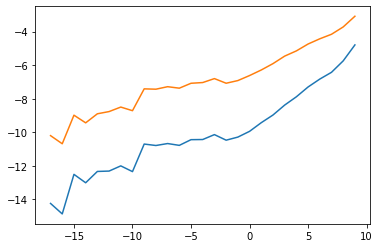

In [14]:
from matplotlib import pyplot as plt
plt.plot(hd1.index, hd1['Worst_score5'])
plt.plot(hd1.index, hd1['Worst_score10'])
plt.show()

NameError: ignored

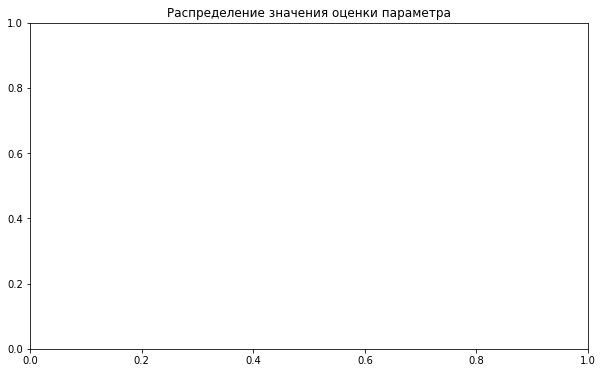

In [11]:
from matplotlib import pyplot as plt
bins = [i + -16.001 for i in range(27)]
plt.figure(figsize=(10, 6))
plt.title("Распределение значения оценки параметра")
plt.hist(
    y_test,
    bins = bins,
    alpha = 0.6,
    color = 'orange',
    label = 'Реальное распределение'
)
plt.hist(
    y,
    bins = bins,
    alpha = 0.6,
    color = 'green',
    label = 'RNN'
)
plt.legend()
plt.show()